# The flexible interface

In the previous tutorial, we have demonstrated how `sbi` can be used to run simulation-based inference with just a single line of code.

In addition to this simple interface, `sbi` also provides a **flexible interface** which unlocks several additional features implemented in `sbi`.

## Features

The flexible interface allows you to customize the following:

- performing sequential posterior estimation by using `num_rounds>1`. This can decrease the number of simulations one has to run, but the inference procedure is no longer amortized.  
- specify your own density estimator, or change hyperparameters of existing ones (e.g. number of hidden units for [NSF](https://arxiv.org/abs/1906.04032)).
- run simulations in batches, which can speed up simulations.
- when it makes sense, choose between different methods to sample from the posterior.
- use calibration kernels as proposed by [Lueckmann, Goncalves et al. 2017](https://arxiv.org/abs/1711.01861).

## Linear Gaussian example

In [1]:
import torch

from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
import sbi.utils as utils

We will show an example of how we can use the flexible interface to infer the posterior for an example with a Gaussian likelihood (same example as before). After importing the inference method we want, `SNPE`, a function to prepare the input `prepare_for_sbi` and a factory for density estimators `posterior_nn` above, we define the simulator and prior:

In [2]:
num_dim = 3
prior = utils.BoxUniform(low=-2*torch.ones(num_dim), 
                         high=2*torch.ones(num_dim))

In [3]:
def linear_gaussian(theta):
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In the advanced mode, you have to ensure that your simulator and prior adhere the requirements of `sbi`. You can do so with the `prepare_for_sbi()` function. In addition `prepare_for_sbi()` returns the `x_shape`, which is the shape of a single simulation output.

In [4]:
simulator, prior, x_shape = prepare_for_sbi(linear_gaussian, prior)

You can then use the `prior` and `x_shape` object to specify a custom density estimator. Since we use S*N*PE, we specifiy a neural network targeting the *posterior* (hence the call to `posterior_nn()`). In this example, we will create a neural spline flow (`'nsf'`) with `60` hidden units and `3` transform layers:

In [5]:
my_density_estimator = posterior_nn('nsf', prior, x_shape, hidden_features=60, 
                                    flow_num_transforms=3)

We will use `SNPE` with a `simulation_batch_size=10`, i.e. `10` simulations will be passed to the simulator which will then handle the simulations in a vectorized way (note that your simulator has to support this in order to use this feature):

In [6]:
inference = SNPE(simulator, prior, x_shape, density_estimator=my_density_estimator, 
                 show_progress_bars=False)

And we can run inference. In this example, we will run inference over `2` rounds, potentially leading to a more focused posterior around the observation `x_o`.

In [7]:
x_o = torch.zeros(3,)
posterior = inference(num_rounds=2, x_o=x_o, num_simulations_per_round=1000)

Neural network successfully converged after 94 epochs.
Neural network successfully converged after 32 epochs.


 Note that, for `num_rounds>1`, the posterior is no longer amortized: it will give good results when sampled around `x=observation`, but possibly bad results for other `x`.

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the easy interface.

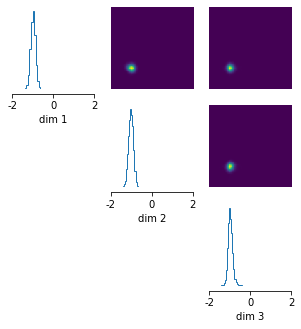

In [10]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = utils.pairplot(posterior_samples, limits=[[-2,2],[-2,2],[-2,2]], 
                   fig_size=(5,5))

We can always print the posterior to know how it was trained:

In [11]:
print(posterior)

Posterior conditional density p(θ|x) focused at x_o=[[0.0, 0.0, 0.0]]  with default evaluation at x=[[0.0, 0.0, 0.0]].

This neural posterior was obtained with a SNPE-class method using a flow.
